# 1 正则化线性回归

## 1.1 可视化数据集

In [1]:
import numpy as np
import scipy.io as sio
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_data():
    d = sio.loadmat('ex5data1.mat')
    return map(np.ravel,[d['X'],d['y'],d['Xval'], d['yval'], d['Xtest'], d['ytest']])

In [3]:
X, y, Xval, yval, Xtest, ytest = load_data()

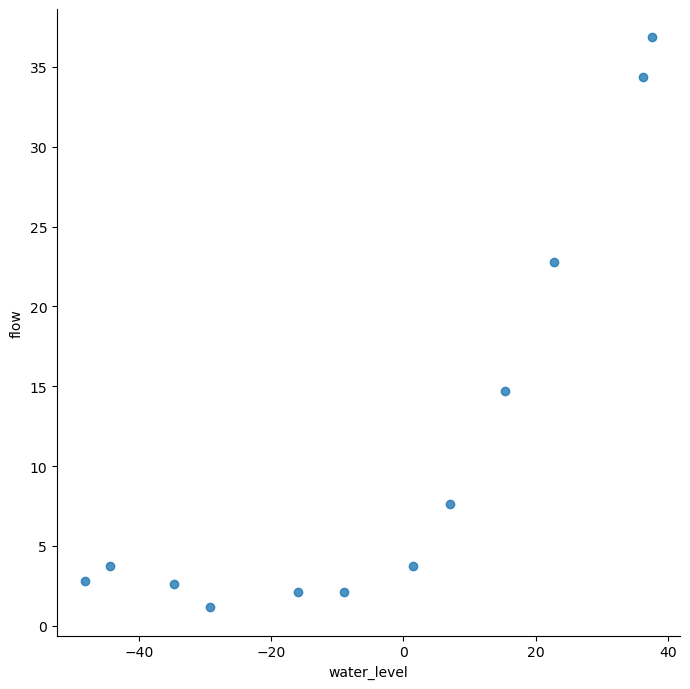

In [4]:
df = pd.DataFrame({'water_level':X,'flow':y})

sns.lmplot(data=df,x='water_level',y='flow',fit_reg=False,height=7)
plt.show()

In [5]:
#添加偏置列
X, Xval, Xtest = [np.insert(x.reshape(x.shape[0], 1), 0, np.ones(x.shape[0]), axis=1) for x in (X, Xval, Xtest)]

## 1.2 正则化线性回归代价函数

In [6]:
def cost(theta,X,y):
    m = X.shape[0]
    
    inner = X @ theta -y # m*1 numpy一维数组是列向量
    square_sum = inner.T @ inner
    cost = square_sum /(2*m)
    
    return cost
    

In [7]:
def costReg(theta,X,y,learning_rate):
    m = X.shape[0]
    regularized_term = (learning_rate / (2*m)) *np.power(theta[1:],2).sum()
    
    return cost(theta,X,y) + regularized_term

In [8]:
theta = np.ones(X.shape[1])
costReg(theta,X,y,1),theta

(303.9931922202643, array([1., 1.]))

## 1.3 正则化线性回归梯度

In [9]:
def gradient(theta,X,y):
    m = X.shape[0]
    
    inner = X.T @ (X@theta-y)
    
    return inner /m 

In [10]:
def gradientReg(theta, X, y, learning_rate):
    m = X.shape[0]
    
    regularized_term = theta.copy()
    regularized_term[0] = 0
    
    regularized_term = (learning_rate/m) *regularized_term
    
    return gradient(theta,X,y) + regularized_term

In [11]:
gradientReg(theta,X,y,1)

array([-15.30301567, 598.25074417])

## 1.4 拟合线性回归

λ = 0

In [12]:
def linear_regression_np(theta,X,y,learning_rate):
    """linear regression
        args:
            theta: init 参数
            X: feature matrix, (m, n+1) # with incercept x0=1
            y: target vector, (m, )
            l: lambda constant for regularization
            
        return: trained parameters
    """
    
    # train it
    res = opt.minimize(fun=costReg,
                       x0=theta,
                       args=(X, y, learning_rate),
                       method='TNC',
                       jac=gradientReg,
                       options={'disp': True})
    return res
    

In [13]:
theta = np.zeros(X.shape[1])

final_theta = linear_regression_np(theta,X,y,0).get('x')
final_theta,theta.shape,X.shape,y.shape,type(theta),type(X),type(y)

(array([13.08790351,  0.36777923]),
 (2,),
 (12, 2),
 (12,),
 numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray)

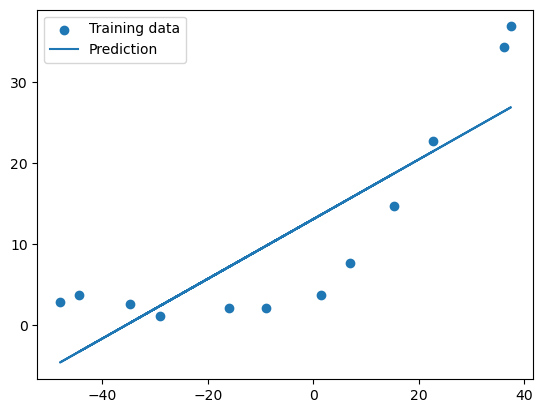

In [14]:
b = final_theta[0] # intercept
m = final_theta[1] # slope

plt.scatter(X[:,1], y, label="Training data")
plt.plot(X[:, 1], X[:, 1]*m + b, label="Prediction")
plt.legend(loc=2)
plt.show()

# 2 偏差和方差

## 2.1 学习曲线

In [15]:
training_cost,cv_cost = [],[]

In [16]:
m = X.shape[0]
for i in range(1,m+1):
    res = linear_regression_np(theta,X[:i,:],y[:i],0)
    
    tc = costReg(res.x, X[:i, :], y[:i], 0)
    cv = costReg(res.x, Xval, yval, 0)
    
    training_cost.append(tc)
    cv_cost.append(cv)

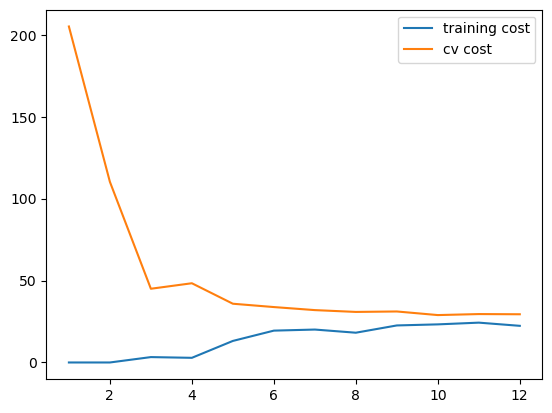

In [17]:
plt.plot(np.arange(1,m+1) , training_cost,label='training cost')
plt.plot(np.arange(1, m+1), cv_cost, label='cv cost')
plt.legend(loc=1)
plt.show()

# 3 多项式回归 

## 创建多项式特征

In [18]:
def poly_features(x, power, as_ndarray=False):
    """
        将x列向量按照不同的次方，一列一列的添加到data中
        
        返回dataframe
    """
    data = {'f{}'.format(i): np.power(x, i) for i in range(1, power + 1)}
    df = pd.DataFrame(data)

    return df.as_matrix() if as_ndarray else df

In [19]:
def normalize_feature(df):
    """
        将dataframe每一列都归一化
    """
    """Applies function along input axis(default 0) of DataFrame."""
    return df.apply(lambda column: (column - column.mean()) / column.std())

In [20]:
def prepare_poly_data(*args, power):
    """
    args: keep feeding in X, Xval, or Xtest
        will return in the same order
        将arg中的所有列向量，都按照不同的次方展开成多维矩阵
        
    """
    def prepare(x):
        # expand feature
        df = poly_features(x, power=power)

        # normalization
        ndarr = np.array(normalize_feature(df))

        # add intercept term
        return np.insert(ndarr, 0, np.ones(ndarr.shape[0]), axis=1)

    return [prepare(x) for x in args]

In [21]:
X2, y2, Xval2, yval2, Xtest2, ytest2 = load_data()

In [22]:
poly_features(X2, power=3)

,f1,f2,f3
0,-15.936758,253.980260,-4047.621971
1,-29.152979,849.896197,-24777.006175
2,36.189549,1309.683430,47396.852168
3,37.492187,1405.664111,52701.422173
4,-48.058829,2309.651088,-110999.127750
5,-8.941458,79.949670,-714.866612
6,15.307793,234.328523,3587.052500
7,-34.706266,1204.524887,-41804.560890
8,1.389154,1.929750,2.680720
9,-44.383760,1969.918139,-87432.373590


In [23]:
# 归一化
normalize_feature(poly_features(X2, power=3))

,f1,f2,f3
0,-0.362141,-0.755087,0.182226
1,-0.803205,0.001258,-0.247937
2,1.377467,0.584827,1.249769
3,1.420940,0.706647,1.359846
4,-1.434149,1.854000,-2.037163
5,-0.128687,-0.975969,0.251385
6,0.680582,-0.780029,0.340656
7,-0.988534,0.451358,-0.601282
8,0.216076,-1.074993,0.266275
9,-1.311501,1.422806,-1.548121


## 3.1 学习多项式回归

准备多项式回归

In [24]:
X_poly, Xval_poly, Xtest_poly= prepare_poly_data(X2, Xval2, Xtest2, power=8)
X_poly[:3, :]

array([[ 1.00000000e+00, -3.62140776e-01, -7.55086688e-01,
         1.82225876e-01, -7.06189908e-01,  3.06617917e-01,
        -5.90877673e-01,  3.44515797e-01, -5.08481165e-01],
       [ 1.00000000e+00, -8.03204845e-01,  1.25825266e-03,
        -2.47936991e-01, -3.27023420e-01,  9.33963187e-02,
        -4.35817606e-01,  2.55416116e-01, -4.48912493e-01],
       [ 1.00000000e+00,  1.37746700e+00,  5.84826715e-01,
         1.24976856e+00,  2.45311974e-01,  9.78359696e-01,
        -1.21556976e-02,  7.56568484e-01, -1.70352114e-01]])

## 画出学习曲线

In [25]:
def plot_learning_curve(X, y, Xval, yval, learning_rate):
    training_cost, cv_cost = [], []
    m = X.shape[0]
    theta = np.zeros(X.shape[1])
    
    for i in range(1, m + 1):
        # regularization applies here for fitting parameters
        res = linear_regression_np(theta,X[:i, :], y[:i], learning_rate)

        # remember, when you compute the cost here, you are computing
        # non-regularized cost. Regularization is used to fit parameters only
        tc = cost(res.x, X[:i, :], y[:i])
        cv = cost(res.x, Xval, yval)

        training_cost.append(tc)
        cv_cost.append(cv)

    plt.plot(np.arange(1, m + 1), training_cost, label='training cost')
    plt.plot(np.arange(1, m + 1), cv_cost, label='cv cost')
    plt.legend(loc=1)

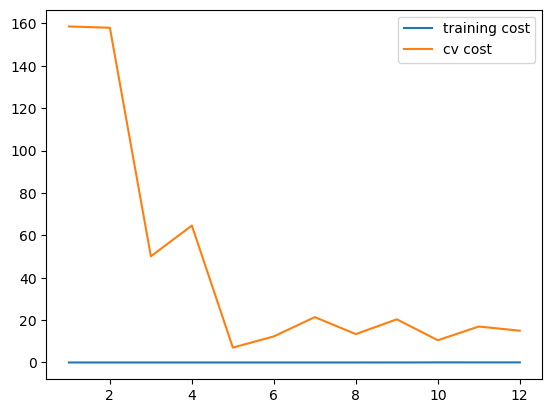

In [26]:
plot_learning_curve(X_poly, y2, Xval_poly, yval2, 0)
plt.show()

## 3.2 调整正则化参数

## λ = 1 减轻了过拟合

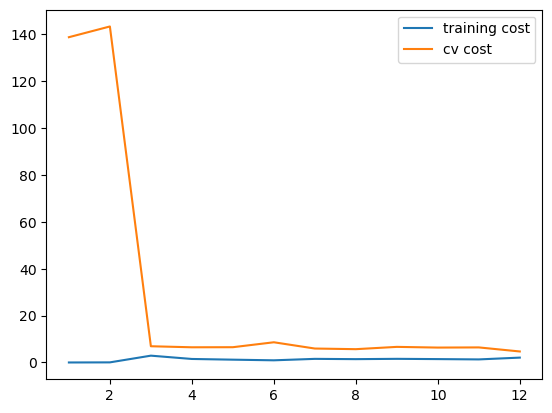

In [27]:
plot_learning_curve(X_poly, y2, Xval_poly, yval2, 1)
plt.show()

## λ = 100 欠拟合

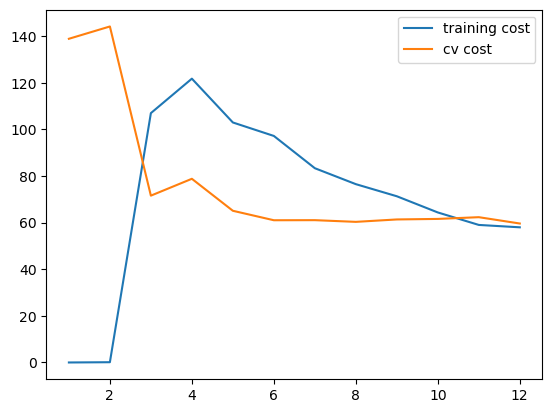

In [28]:
plot_learning_curve(X_poly, y2, Xval_poly, yval2, 100)
plt.show()

## 3.3 选择λ 利用交叉验证集

In [29]:
l_candidate = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
training_cost, cv_cost = [], []

In [30]:
for l in l_candidate:
    theta = np.zeros(X_poly.shape[1])
    res = linear_regression_np(theta,X_poly, y2, l)
    
    tc = cost(res.x, X_poly, y2)
    cv = cost(res.x, Xval_poly, yval2)
    
    training_cost.append(tc)
    cv_cost.append(cv)

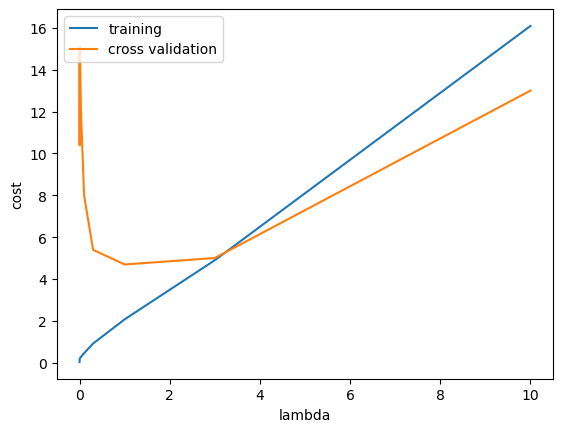

In [31]:
plt.plot(l_candidate, training_cost, label='training')
plt.plot(l_candidate, cv_cost, label='cross validation')
plt.legend(loc=2)

plt.xlabel('lambda')

plt.ylabel('cost')
plt.show()

In [32]:
#验证集最小的lambda的位置
l_candidate[np.argmin(cv_cost)]

1

## 3.4 计算测试误差

In [33]:
theta =np.zeros(X_poly.shape[1])
theta = linear_regression_np(theta,X_poly, y2, 1).x
cost(theta,Xtest_poly,ytest2)

7.466303898729558